<a href="https://colab.research.google.com/github/apple9855/tf_advanced_tech/blob/main/Notebooks/13_Autoencoders_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder in MNIST

# 1.First Autoencoder (Little experiment)

In this lab, you will build your first simple autoencoder. This will take in three-dimensional data, encodes it to two dimensions, and decodes it back to 3D.

## Imports

In [ ]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Prepare and preview the dataset

You will first create a synthetic dataset to act as input to the autoencoder. You can do that with the function below.

In [ ]:
def generate_data(m):
    '''plots m random points on a 3D plane'''

    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:,0] = np.cos(angles) + np.sin(angles)/2 + 0.1 * np.random.randn(m)/2
    data[:,1] = np.sin(angles) * 0.7 + 0.1 * np.random.randn(m) / 2
    data[:,2] = data[:, 0] * 0.1 + data[:, 1] * 0.3 + 0.1 * np.random.randn(m)

    return data

<ipython-input-3-42bc7d7259f7>:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter3D(X_train[:, 0], X_train[:, 1], X_train[:, 2], cmap='Reds');


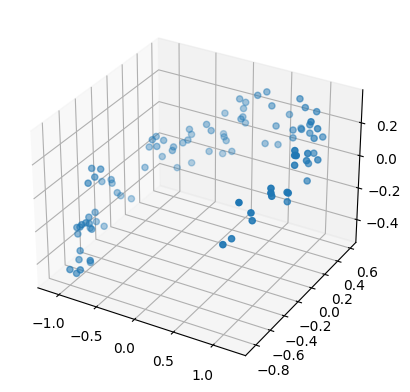

In [ ]:
# use the function above to generate data points
X_train = generate_data(100)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

# preview the data
ax = plt.axes(projection='3d')
ax.scatter3D(X_train[:, 0], X_train[:, 1], X_train[:, 2], cmap='Reds');

## Build the Model

Now you will build the simple encoder-decoder model. Notice the number of neurons in each Dense layer. The model will contract in the encoder then expand in the decoder.

In [ ]:
encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])

autoencoder = keras.models.Sequential([encoder, decoder])

## Compile the Model

You can then setup the model for training.

In [ ]:
autoencoder.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=0.1))

## Train the Model

You will configure the training to also use the input data as your target output. In our example, that will be `X_train`.

In [ ]:
history = autoencoder.fit(X_train, X_train, epochs=200)

Epoch 1/200
4/4 [==============================] - 2s 14ms/step - loss: 0.2161
Epoch 2/200
4/4 [==============================] - 0s 4ms/step - loss: 0.2064
Epoch 3/200
4/4 [==============================] - 0s 4ms/step - loss: 0.1976
Epoch 4/200
4/4 [==============================] - 0s 5ms/step - loss: 0.1900
Epoch 5/200
4/4 [==============================] - 0s 4ms/step - loss: 0.1825
Epoch 6/200
4/4 [==============================] - 0s 4ms/step - loss: 0.1749
Epoch 7/200
4/4 [==============================] - 0s 4ms/step - loss: 0.1684
Epoch 8/200
4/4 [==============================] - 0s 4ms/step - loss: 0.1619
Epoch 9/200
4/4 [==============================] - 0s 4ms/step - loss: 0.1556
Epoch 10/200
4/4 [==============================] - 0s 4ms/step - loss: 0.1506
Epoch 11/200
4/4 [==============================] - 0s 4ms/step - loss: 0.1463
Epoch 12/200
4/4 [==============================] - 0s 4ms/step - loss: 0.1422
Epoch 13/200
4/4 [==============================] - 0s 4ms/s

## Plot the encoder output

As mentioned, you can use the encoder to compress the input to two dimensions.

In [ ]:
# encode the data
codings = encoder.predict(X_train)

# see a sample input-encoder output pair
print(f'input point: {X_train[0]}')
print(f'encoded point: {codings[0]}')

4/4 [==============================] - 0s 2ms/step
input point: [-0.69927578  0.06287471  0.07790212]
encoded point: [ 0.04790104 -0.72774357]


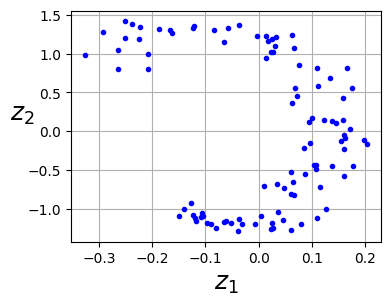

In [ ]:
# plot all encoder outputs
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
plt.show()

## Plot the Decoder output

The decoder then tries to reconstruct the original input. See the outputs below. You will see that although not perfect, it still follows the general shape of the original input.

In [ ]:
# decode the encoder output
decodings = decoder.predict(codings)

# see a sample output for a single point
print(f'input point: {X_train[0]}')
print(f'encoded point: {codings[0]}')
print(f'decoded point: {decodings[0]}')

4/4 [==============================] - 0s 3ms/step
input point: [-0.69927578  0.06287471  0.07790212]
encoded point: [ 0.04790104 -0.72774357]
decoded point: [-0.6550705  -0.14589663 -0.12572344]


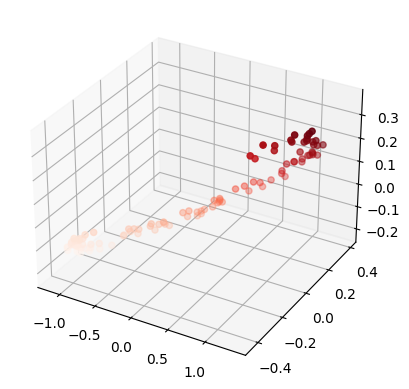

In [ ]:
# plot the decoder output
ax = plt.axes(projection='3d')
ax.scatter3D(decodings[:, 0], decodings[:, 1], decodings[:, 2], c=decodings[:, 0], cmap='Reds');

That's it for this simple demonstration of the autoencoder!

# 2.MNIST Autoencoder (Shallow)

You will now work on an autoencoder that works on the [MNIST dataset](https://www.tensorflow.org/datasets/catalog/mnist). This will encode the inputs to lower resolution images. The decoder should then be able to generate the original input from this compressed representation.

In [ ]:
import tensorflow_datasets as tfds

## Prepare the Dataset

You will load the MNIST data from TFDS into train and test sets. Let's first define a preprocessing function for normalizing and flattening the images. Since we'll be training an autoencoder, this will return `image, image` because the input will also be the target or label while training.


In [ ]:
def map_image(image, label):
  '''Normalizes and flattens the image. Returns image as input and label.'''
  image = tf.cast(image, dtype=tf.float32)
  image = image / 255.0
  image = tf.reshape(image, shape=(784,))

  return image, image

In [ ]:
# Load the train and test sets from TFDS

BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1024

train_dataset = tfds.load('mnist', as_supervised=True, split="train")
train_dataset = train_dataset.map(map_image)
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat()

test_dataset = tfds.load('mnist', as_supervised=True, split="test")
test_dataset = test_dataset.map(map_image)
test_dataset = test_dataset.batch(BATCH_SIZE).repeat()

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


## Build the Model

You will now build a simple autoencoder to ingest the data. Like before, the encoder will compress the input and reconstructs it in the decoder output.

In [ ]:
def simple_autoencoder(inputs):
  '''Builds the encoder and decoder using Dense layers.'''
  encoder = tf.keras.layers.Dense(units=32, activation='relu')(inputs)
  decoder = tf.keras.layers.Dense(units=784, activation='sigmoid')(encoder)

  return encoder, decoder

# set the input shape
inputs =  tf.keras.layers.Input(shape=(784,))

# get the encoder and decoder output
encoder_output, decoder_output = simple_autoencoder(inputs)

# setup the encoder because you will visualize its output later
encoder_model = tf.keras.Model(inputs=inputs, outputs=encoder_output)

# setup the autoencoder
autoencoder_model = tf.keras.Model(inputs=inputs, outputs=decoder_output)

## Compile the Model

You will setup the model for training. You can use binary crossentropy to measure the loss between pixel values that range from 0 (black) to 1 (white).

In [ ]:
autoencoder_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy')

## Train the Model

In [ ]:
train_steps = 60000 // BATCH_SIZE
simple_auto_history = autoencoder_model.fit(train_dataset, steps_per_epoch=train_steps, epochs=50)

Epoch 1/50
468/468 [==============================] - 18s 26ms/step - loss: 0.2304
Epoch 2/50
468/468 [==============================] - 5s 10ms/step - loss: 0.1411
Epoch 3/50
468/468 [==============================] - 3s 7ms/step - loss: 0.1184
Epoch 4/50
468/468 [==============================] - 4s 8ms/step - loss: 0.1073
Epoch 5/50
468/468 [==============================] - 3s 6ms/step - loss: 0.1010
Epoch 6/50
468/468 [==============================] - 3s 6ms/step - loss: 0.0974
Epoch 7/50
468/468 [==============================] - 3s 6ms/step - loss: 0.0957
Epoch 8/50
468/468 [==============================] - 4s 8ms/step - loss: 0.0948
Epoch 9/50
468/468 [==============================] - 3s 6ms/step - loss: 0.0943
Epoch 10/50
468/468 [==============================] - 3s 6ms/step - loss: 0.0941
Epoch 11/50
468/468 [==============================] - 3s 6ms/step - loss: 0.0938
Epoch 12/50
468/468 [==============================] - 4s 8ms/step - loss: 0.0937
Epoch 13/50
468/468 [=

## Display sample results

You can now visualize the results. The utility functions below will help in plotting the encoded and decoded values.

In [ ]:
def display_one_row(disp_images, offset, shape=(28, 28)):
  '''Display sample outputs in one row.'''
  for idx, test_image in enumerate(disp_images):
    plt.subplot(3, 10, offset + idx + 1)
    plt.xticks([])
    plt.yticks([])
    test_image = np.reshape(test_image, shape)
    plt.imshow(test_image, cmap='gray')


def display_results(disp_input_images, disp_encoded, disp_predicted, enc_shape=(8,4)):
  '''Displays the input, encoded, and decoded output values.'''
  plt.figure(figsize=(15, 5))
  display_one_row(disp_input_images, 0, shape=(28,28,))
  display_one_row(disp_encoded, 10, shape=enc_shape)
  display_one_row(disp_predicted, 20, shape=(28,28,))

1/1 [==============================] - 0s 169ms/step


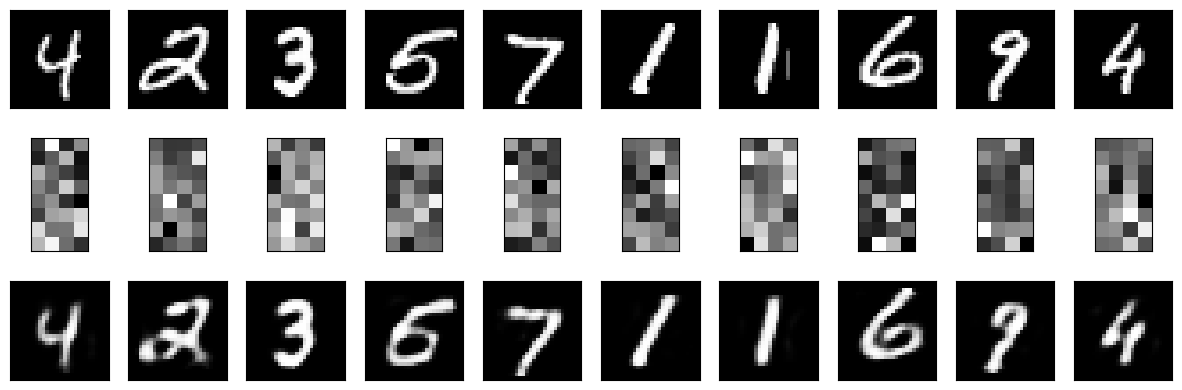

In [ ]:
# take 1 batch of the dataset
test_dataset = test_dataset.take(1)

# take the input images and put them in a list
output_samples = []
for input_image, image in tfds.as_numpy(test_dataset):
      output_samples = input_image

# pick 10 random numbers to be used as indices to the list above
idxs = np.random.choice(BATCH_SIZE, size=10)

# get the encoder output
encoded_predicted = encoder_model.predict(test_dataset)

# get a prediction for the test batch
simple_predicted = autoencoder_model.predict(test_dataset)

# display the 10 samples, encodings and decoded values!
display_results(output_samples[idxs], encoded_predicted[idxs], simple_predicted[idxs])

# 3.MNIST Deep Autoencoder

Welcome back! In this lab, you will extend the shallow autoencoder you built in the previous exercise. The model here will have a deeper network so it can handle more complex images.

## Build the Model

As mentioned, you will have a deeper network for the autoencoder. Compare the layers here with that of the shallow network you built in the previous lab.

In [ ]:
def deep_autoencoder():
  '''Builds the encoder and decoder using Dense layers.'''
  encoder = tf.keras.layers.Dense(units=128, activation='relu')(inputs)
  encoder = tf.keras.layers.Dense(units=64, activation='relu')(encoder)
  encoder = tf.keras.layers.Dense(units=32, activation='relu')(encoder)

  decoder = tf.keras.layers.Dense(units=64, activation='relu')(encoder)
  decoder = tf.keras.layers.Dense(units=128, activation='relu')(decoder)
  decoder = tf.keras.layers.Dense(units=784, activation='sigmoid')(decoder)

  return encoder, decoder

# set the input tensor
inputs =  tf.keras.layers.Input(shape=(784,))

# get the encoder and decoder output
deep_encoder_output, deep_autoencoder_output = deep_autoencoder()

# setup the encoder because you will visualize its output later
deep_encoder_model = tf.keras.Model(inputs=inputs, outputs=deep_encoder_output)

# setup the autoencoder
deep_autoencoder_model = tf.keras.Model(inputs=inputs, outputs=deep_autoencoder_output)

## Compile and Train the Model

In [ ]:
train_steps = 60000 // BATCH_SIZE

deep_autoencoder_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy')
deep_auto_history = deep_autoencoder_model.fit(train_dataset, steps_per_epoch=train_steps, epochs=50)

Epoch 1/50
468/468 [==============================] - 22s 21ms/step - loss: 0.2001
Epoch 2/50
468/468 [==============================] - 3s 7ms/step - loss: 0.1262
Epoch 3/50
468/468 [==============================] - 3s 6ms/step - loss: 0.1132
Epoch 4/50
468/468 [==============================] - 3s 6ms/step - loss: 0.1067
Epoch 5/50
468/468 [==============================] - 4s 8ms/step - loss: 0.1023
Epoch 6/50
468/468 [==============================] - 3s 7ms/step - loss: 0.0995
Epoch 7/50
468/468 [==============================] - 3s 6ms/step - loss: 0.0971
Epoch 8/50
468/468 [==============================] - 3s 6ms/step - loss: 0.0951
Epoch 9/50
468/468 [==============================] - 4s 8ms/step - loss: 0.0934
Epoch 10/50
468/468 [==============================] - 3s 7ms/step - loss: 0.0921
Epoch 11/50
468/468 [==============================] - 3s 6ms/step - loss: 0.0910
Epoch 12/50
468/468 [==============================] - 3s 6ms/step - loss: 0.0903
Epoch 13/50
468/468 [==

## Display sample results

See the results using the model you just trained.

1/1 [==============================] - 0s 208ms/step


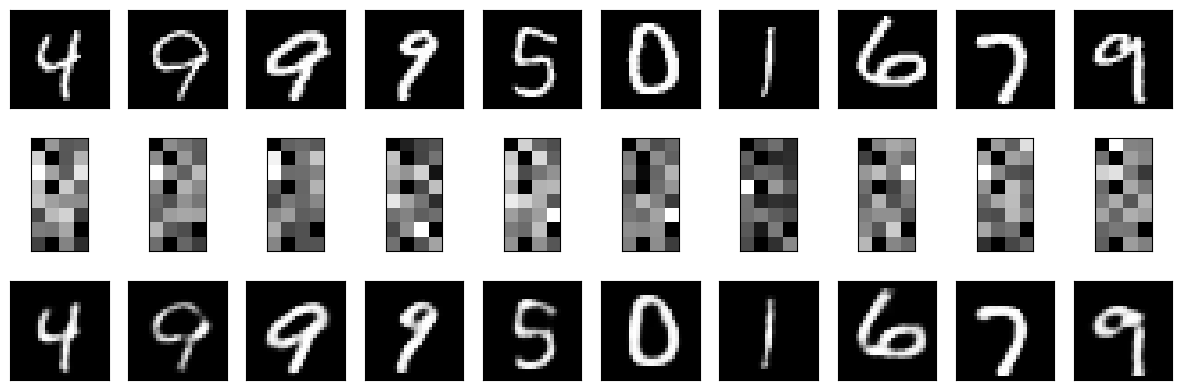

In [ ]:
# take 1 batch of the dataset
test_dataset = test_dataset.take(1)

# take the input images and put them in a list
output_samples = []
for input_image, image in tfds.as_numpy(test_dataset):
      output_samples = input_image

# pick 10 random numbers to be used as indices to the list above
idxs = np.random.choice(BATCH_SIZE, size=10)

# get the encoder output
encoded_predicted = deep_encoder_model.predict(test_dataset)

# get a prediction for the test batch
deep_predicted = deep_autoencoder_model.predict(test_dataset)

# display the 10 samples, encodings and decoded values!
display_results(output_samples[idxs], encoded_predicted[idxs], deep_predicted[idxs])